In [1]:
import findspark
findspark.init()
from  pyspark.sql.functions import input_file_name
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("ClusterAnalysis").config('spark.sql.shuffle.partitions','10').getOrCreate()




22/01/10 19:54:55 WARN Utils: Your hostname, daniyal resolves to a loopback address: 127.0.1.1; using 192.168.228.38 instead (on interface wlp1s0)
22/01/10 19:54:55 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/01/10 19:54:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/01/10 19:54:57 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/01/10 19:54:57 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/01/10 19:54:57 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
22/01/10 19:54:57 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.


In [4]:
!pip install findspark

Defaulting to user installation because normal site-packages is not writeable


In [2]:
txtFiles = spark.read.text('cnn_stories/cnn/stories/*', wholetext=True).withColumn("filename", input_file_name())
print(txtFiles.count())

92579


In [3]:
txtFiles.show()

+--------------------+--------------------+
|               value|            filename|
+--------------------+--------------------+
|(CNN)The nominati...|file:/home/daniya...|
|(CNN) -- Listed b...|file:/home/daniya...|
|President Barack ...|file:/home/daniya...|
|Typhoon Haiyan, o...|file:/home/daniya...|
|The struggle betw...|file:/home/daniya...|
|New documents sho...|file:/home/daniya...|
|(CNN) -- Egyptian...|file:/home/daniya...|
|(CNN) -- Welcome ...|file:/home/daniya...|
|WASHINGTON (CNN) ...|file:/home/daniya...|
|ISIS militants ha...|file:/home/daniya...|
|(CNN) -- Beef fro...|file:/home/daniya...|
|Washington (CNN) ...|file:/home/daniya...|
|Simferopol, Ukrai...|file:/home/daniya...|
|Kiev (CNN) -- Rus...|file:/home/daniya...|
|Drones are everyw...|file:/home/daniya...|
|BOGOTA, Colombia ...|file:/home/daniya...|
|BOGOTA, Colombia ...|file:/home/daniya...|
|You wanted to kno...|file:/home/daniya...|
|You wanted to kno...|file:/home/daniya...|
|Washington (CNN) ...|file:/home

In [18]:
from pyspark.ml.feature import Tokenizer

In [19]:
tokens = Tokenizer(inputCol="value", outputCol="words")

In [20]:
tokenizedDF = tokens.transform(txtFiles)

In [21]:
tokenizedDF.show()


+--------------------+--------------------+--------------------+
|               value|            filename|               words|
+--------------------+--------------------+--------------------+
|(CNN)The nominati...|file:/home/daniya...|[(cnn)the, nomina...|
|(CNN) -- Listed b...|file:/home/daniya...|[(cnn), --, liste...|
|President Barack ...|file:/home/daniya...|[president, barac...|
|Typhoon Haiyan, o...|file:/home/daniya...|[typhoon, haiyan,...|
|The struggle betw...|file:/home/daniya...|[the, struggle, b...|
|New documents sho...|file:/home/daniya...|[new, documents, ...|
|(CNN) -- Egyptian...|file:/home/daniya...|[(cnn), --, egypt...|
|(CNN) -- Welcome ...|file:/home/daniya...|[(cnn), --, welco...|
|WASHINGTON (CNN) ...|file:/home/daniya...|[washington, (cnn...|
|ISIS militants ha...|file:/home/daniya...|[isis, militants,...|
|(CNN) -- Beef fro...|file:/home/daniya...|[(cnn), --, beef,...|
|Washington (CNN) ...|file:/home/daniya...|[washington, (cnn...|
|Simferopol, Ukrai...|fil

In [4]:
from pyspark.ml.feature import RegexTokenizer
regex = RegexTokenizer(inputCol='value', outputCol='words',pattern='\\W')

regexDF = regex.transform(txtFiles)

regexDF.select('words').show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [5]:
from pyspark.ml.feature import HashingTF, IDF

tf = HashingTF(inputCol='words', outputCol='rawFeatures', numFeatures=2000)


In [6]:
featuredDF = tf.transform(regexDF)
featuredDF.select('rawFeatures').show(5,truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from pyspark.ml.feature import PCA
pcaDF = featuredDF.select('rawFeatures')
pca = PCA(k=500, inputCol="rawFeatures", outputCol="pcaFeatures")
pcamodel = pca.fit(pcaDF).transform(pcaDF)

In [ ]:

pcamodel.select('pcaFeatures').show(truncate=False)

In [ ]:

#----------------KMeans
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

eval_result =[]
evaluator = ClusteringEvaluator(featuresCol='rawFeatures', predictionCol='prediction', metricName='silhouette', distanceMeasure='squaredEuclidean')
kmeans = KMeans(featuresCol='rawFeatures',
predictionCol='prediction',
k=11,
initMode='k-means||',
initSteps=5,
tol=0.0001,
maxIter=5,
seed=None,
distanceMeasure='euclidean')

kmeansModel = kmeans.fit(featuredDF)
kmeansresult = kmeansModel.transform(featuredDF)

result = evaluator.evaluate(kmeansresult)
eval_result.append(result)

In [27]:
eval_result


[0.38805997883118665,
 0.326150961367271,
 0.28833661170212876,
 0.24449500673760247,
 0.24945251017450765,
 0.10237089211497825,
 0.11027423965313041]

Text(0, 0.5, 'cost')

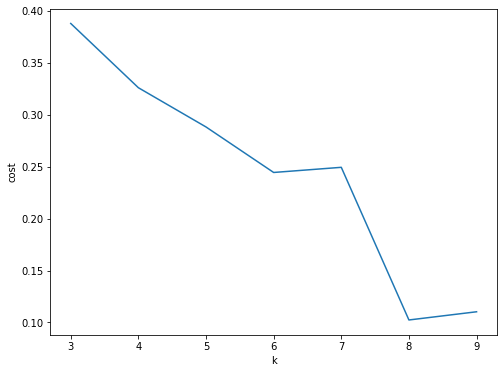

In [31]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(3,10),eval_result)
ax.set_xlabel('k')
ax.set_ylabel('cost')

     |████████████████████████████████| 11.3 MB 597 kB/s            
     |████████████████████████████████| 880 kB 1.6 MB/s            
     |████████████████████████████████| 1.2 MB 523 kB/s            
     |████████████████████████████████| 3.1 MB 494 kB/s            
